# OBS Dictionary Retrieval

Reproduce the Top-N retrieval accuracy from the paper.

**Reference**: *Decoding Ancient Oracle Bone Script via Generative Dictionary Retrieval*


In [ ]:
import os
import numpy as np
import torch
from tqdm.auto import tqdm  

# Load pre-extracted features
features_dir = '../data/features'
dict_data = torch.load(os.path.join(features_dir, 'dict_features.pt'))
query_data = torch.load(os.path.join(features_dir, 'query_features.pt'))

query_features = query_data['features']
query_labels = query_data['labels']
gallery_features = dict_data['features']
gallery_labels = dict_data['labels']

print(f"Query: {len(query_labels)} images")
print(f"Gallery: {len(gallery_labels)} images")


Query: 6830 images
Gallery: 6830 images


/tmp/ipykernel_237460/3228884401.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dict_data = torch.load(os.path.join(features_dir, 'dict_features.pt'))
/tmp/ipykernel_23

In [2]:
def voting_rerank(qf, ql, gf, gl):
    """Voting-based reranking (matches infer.py exactly)."""
    query = qf.view(-1, 1)
    score = torch.mm(gf, query).squeeze(1).cpu().numpy()
    index = np.argsort(score)[::-1]
    
    query_index = np.argwhere(gl == ql)
    good_index = query_index
    junk_index = np.argwhere(gl == -1)
    
    if good_index.size == 0:
        return [0] * len(index)
    
    mask = np.in1d(index, junk_index, invert=True)
    index = index[mask]
    
    mask = np.in1d(index, good_index)
    rows_good = np.argwhere(mask == True).flatten()
    
    if len(rows_good) == 0:
        return [0] * len(index)
    
    calculated_label = []
    label_score = {}
    for i in range(rows_good[0] + 1):
        current_label = gl[index[i]]
        if current_label not in calculated_label:
            calculated_label.append(current_label)
            label_index = np.argwhere(gl == current_label)
            label_mask = np.in1d(index, label_index)
            rows_good_label = np.argwhere(label_mask == True).flatten()
            label_score[current_label] = sum(rows_good_label) / len(rows_good_label)
    
    sorted_labels = [k for k, v in sorted(label_score.items(), key=lambda x: x[1])]
    new_ql_rank = len(sorted_labels)
    for i in range(len(sorted_labels)):
        if sorted_labels[i] == ql:
            new_ql_rank = i
            break
    
    new_rank = [0] * len(index)
    for i in range(len(index)):
        if i >= new_ql_rank:
            new_rank[i] = 1
    
    return new_rank


In [3]:
# Compute voting rerank results (matches infer.py)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
query_feature = query_features.to(device)
gallery_feature = gallery_features.to(device)
gallery_label_np = np.array(gallery_labels)

new_rank_all = [0] * len(gallery_labels)

for i in tqdm(range(len(query_labels)), desc="Voting rerank"):
    new_rank_tmp = voting_rerank(
        query_feature[i], 
        query_labels[i], 
        gallery_feature, 
        gallery_label_np
    )
    new_rank_all = [x + y for x, y in zip(new_rank_all, new_rank_tmp)]

new_rank_all = [x / len(query_labels) for x in new_rank_all]


Voting rerank:   0%|          | 0/6830 [00:00<?, ?it/s]

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Prepare Top-N results
num_gallery = len(gallery_labels)
top_ns = [1, 5, 10, 20, 50, 100]
accuracies = [new_rank_all[min(n-1, num_gallery-1)] * 100 for n in top_ns]

# Create a styled DataFrame
results_df = pd.DataFrame({
    'Top-N': [f'Top-{n}' for n in top_ns],
    'Accuracy (%)': [f'{acc:.2f}' for acc in accuracies]
})

# Display as styled table
from IPython.display import display, HTML

html_table = f"""
<div style="margin: 20px 0;">
<h3 style="color: #2c3e50; font-family: Arial;">📊 Retrieval Accuracy Results</h3>
<p style="color: #7f8c8d;">Query: {len(query_labels)} images | Gallery: {len(gallery_labels)} images</p>
<table style="border-collapse: collapse; font-family: Arial; margin: 10px 0;">
<tr style="background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); color: white;">
    <th style="padding: 12px 20px; text-align: center;">Top-N</th>
    <th style="padding: 12px 20px; text-align: center;">Accuracy (%)</th>
</tr>
"""
for i, (n, acc) in enumerate(zip(top_ns, accuracies)):
    bg_color = '#f8f9fa' if i % 2 == 0 else '#ffffff'
    bar_width = acc  # percentage
    html_table += f"""
<tr style="background-color: {bg_color};">
    <td style="padding: 10px 20px; text-align: center; font-weight: bold;">Top-{n}</td>
    <td style="padding: 10px 20px;">
        <div style="display: flex; align-items: center; gap: 10px;">
            <div style="background: linear-gradient(90deg, #667eea 0%, #764ba2 100%); 
                        height: 20px; width: {bar_width}%; border-radius: 4px;"></div>
            <span style="font-weight: bold; color: #2c3e50;">{acc:.2f}%</span>
        </div>
    </td>
</tr>
"""
html_table += "</table></div>"
display(HTML(html_table))


Top-N,Accuracy (%)
Top-1,21.20%
Top-5,43.28%
Top-10,54.33%
Top-20,66.76%
Top-50,86.15%
Top-100,96.85%


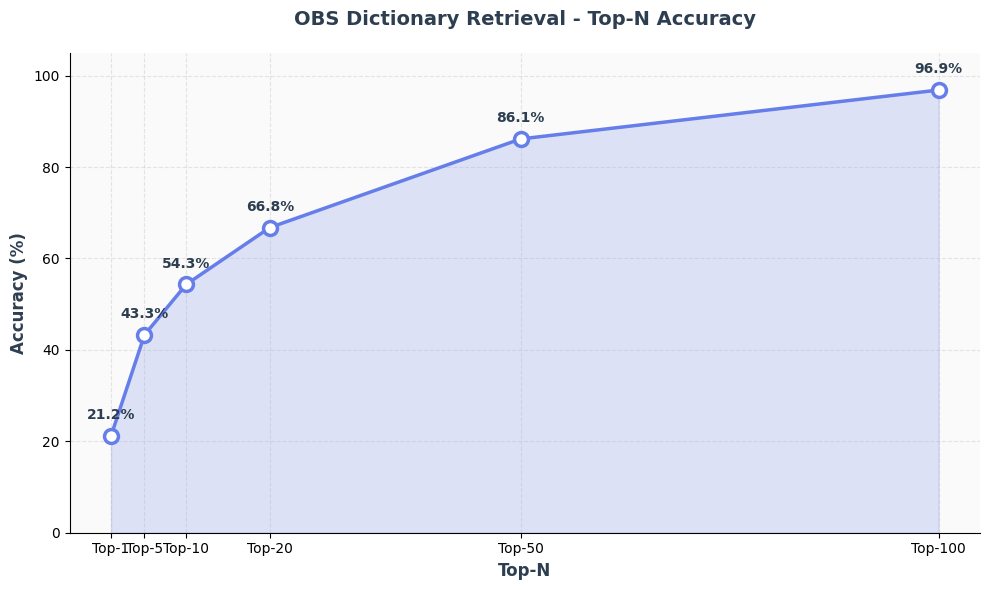


📈 Summary: Top1:21.20 Top10:54.33 Top20:66.76 Top50:86.15 Top100:96.85


In [7]:
# Plot Top-N Accuracy Curve
fig, ax = plt.subplots(figsize=(10, 6))

# Style settings
colors = ['#667eea', '#764ba2']
ax.set_facecolor('#fafafa')
fig.patch.set_facecolor('white')

# Plot line with markers
ax.plot(top_ns, accuracies, 'o-', color='#667eea', linewidth=2.5, 
        markersize=10, markerfacecolor='white', markeredgewidth=2.5)

# Fill area under curve
ax.fill_between(top_ns, accuracies, alpha=0.2, color='#667eea')

# Add value labels on each point
for n, acc in zip(top_ns, accuracies):
    ax.annotate(f'{acc:.1f}%', (n, acc), textcoords="offset points", 
                xytext=(0, 12), ha='center', fontsize=10, fontweight='bold', color='#2c3e50')

# Styling
ax.set_xlabel('Top-N', fontsize=12, fontweight='bold', color='#2c3e50')
ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold', color='#2c3e50')
ax.set_title('OBS Dictionary Retrieval - Top-N Accuracy', fontsize=14, fontweight='bold', color='#2c3e50', pad=20)
ax.set_xticks(top_ns)
ax.set_xticklabels([f'Top-{n}' for n in top_ns])
ax.set_ylim(0, 105)
ax.grid(True, alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Print summary (original format for compatibility)
print('\n📈 Summary: Top1:%.2f Top10:%.2f Top20:%.2f Top50:%.2f Top100:%.2f' % (
    new_rank_all[0] * 100,
    new_rank_all[min(9, num_gallery - 1)] * 100,
    new_rank_all[min(19, num_gallery - 1)] * 100,
    new_rank_all[min(49, num_gallery - 1)] * 100,
    new_rank_all[min(99, num_gallery - 1)] * 100,
))
